In [142]:
using Revise
using Sqra
using Plots
using Arpack
using LinearAlgebra, Random
plotly(fmt=:png)

Plots.PlotlyBackend()

# Simulation

In [342]:
#method = :voronoi
method = :sb

steps = 2_000_000
ncells=6
npicks=300
sigma=.5
prune=Inf

Random.seed!(0)
@time r=Sqra.run(nsteps=steps, method=method, ncells=ncells, npicks=npicks, prune=prune, sigma=sigma, x0=Sqra.x0gen);

Euler Maruyama simulation100%|██████████████████████████| Time: 0:00:03
sparse box picking100%|█████████████████████████████████| Time: 0:00:01
collecting neighbours100%|██████████████████████████████| Time: 0:00:00


length(picks) = 12634
  1.727938 seconds (8.37 M allocations: 1.007 GiB, 26.66% gc time)
  0.009980 seconds (94 allocations: 10.140 MiB)
sparsity: 12634/46656=0.27079046639231824
pruned 38 large outbound rates
pruned 0 states without incoming rates
solving committor...
  8.892168 seconds (100.38 M allocations: 10.115 GiB, 24.97% gc time)


In [343]:
plot(sum(r.Q .> 0, dims=1)|>vec|>sort)

┌ Warning: Kaleido is not available on this system. Julia will be unable to save images of any plots.
└ @ PlotlyBase /Users/alex/.julia/packages/PlotlyBase/a5kqm/src/kaleido.jl:65
┌ Warning: InterruptException()
└ @ PlotlyBase /Users/alex/.julia/packages/PlotlyBase/a5kqm/src/kaleido.jl:66


Base.IOError: IOError: write: broken pipe (EPIPE)

In [347]:
length(r.Q.nzval), size(r.Q)

(99710, (12596, 12596))

In [348]:
using BenchmarkTools

In [349]:
_, pinds = Sqra.prune_Q(r.Q, 100)
QQ, b = Sqra.committor_system(r.Q[pinds, pinds], r.classes[pinds])
b = Float64.(b)
QQ

pruned 5745 large outbound rates
pruned 183 states without incoming rates


6668×6668 SparseMatrixCSC{Float64, Int64} with 35614 stored entries:
⣿⣿⣿⣿⣷⣿⣿⣿⣷⣷⢻⣾⢿⣾⣾⡾⣿⣿⣶⡿⣿⣿⣻⣿⣿⣶⣷⣷⣿⣷⣴⣽⣿⣟⣿⣿⡿⣿⣿⡿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⡳⡿⢽⣿⣿⣻⣏
⣽⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣷⣍⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡻⣿⣿⣿⣿⣽⣿⣾⡾⣿⡿⣿⣿⡯
⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣽⡞⣟⣿⣿⣾⣿⣿⣿⣷⣿⢿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⢿⣿
⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣺⣿⣿⣯⣿⣿⣿⣿⣿⣽⣿⣯⣿⢿⣿⣿⣿⣿⣿⣿⣿⣧
⣻⣶⣳⣿⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣝⣿⣷⣿⣿⣿⣿⢿⣿⣿⣿
⣻⣷⣿⣿⡝⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣺⡿⣿⣿⣿⣟⣟⣿⡿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣿⣷⣿⣏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣾⢭⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣿⣯⣟⢿⢿⣿⣿⣿⣿⣟⣇
⣼⡿⣿⣿⣿⣿⣿⣿⣾⣾⣿⣿⣻⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣶⡻⣟⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣟⣿⣿⣿⣾⣿⡿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣟⣷⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣽⣿⣿⣿⣿⣿⢿⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣟⣿⣿⣿⣷⣿⣿
⢻⣿⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣯⣽⣿⢿⣿⣿⣿⣿⣿⣿⣵⣿⣿⣿⣿⣿⣿⣿⣿⣯⣽⣿⣿⣿⣿⣿
⢽⣿⣿⣿⣿⣮⡿⣷⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⡾⡿⣿⣿
⢿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣟⢿⣿⣿⣿⣿⣿⣿⣿⢮⣿⣿⣿⣿⣿⣿⣿⣿⢿⣷⣿⣟⣿⢿⣿⣿⣿⣼⣯⣿
⣔⣿⣿⣿⣟⣿⣿⣿⣿⣟⢿⣿⣽⣿⣿⣿⣯⢿⣿⣯⣿⣯⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⢿⢿⡺⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⣿⣿⣿⣿⣾⢿⡿⣿⣿⣷⣿⣟⣿⣿⣿⣿⣿⣿⣻⣿⣿⣯
⣿⣿⣟⣏⣾⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿
⣿⣯⣿⣿⣿⣯⣟⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⣾⡯⣛⣿⣿⣿⣿⣾⣿⣽⣿⣿⢿⣷
⣿⡿⡿⢾⡿⡿⣿⣷⠿⣿⣿⣿⣿⣿⣿⣿⠿⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⡿⣿⣿⣿⢿⣷⣿⣿

In [350]:
using IterativeSolvers

In [351]:
@time QQ\x

LoadError: InterruptException:

In [352]:
kwargs = (maxiter=10, verbose=true, log=true)

err(x) = sum(abs2,QQ*x-b)

err (generic function with 1 method)

In [354]:
x,l=IterativeSolvers.lsqr(QQ,b; kwargs...)
err(x)

=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
  1	3.57e+01	6.33e-02	9.46e-02	1.00e+00
  2	3.56e+01	3.84e-02	1.98e-02	9.98e-01
  3	3.55e+01	3.96e-02	1.12e-02	9.96e-01
  4	3.54e+01	3.87e-02	7.60e-03	9.92e-01
  5	3.52e+01	4.07e-02	5.71e-03	9.86e-01
  6	3.49e+01	4.23e-02	4.51e-03	9.77e-01
  7	3.45e+01	4.34e-02	3.70e-03	9.66e-01
  8	3.40e+01	4.54e-02	3.12e-03	9.52e-01
  9	3.34e+01	4.63e-02	2.69e-03	9.36e-01
 10	3.28e+01	4.51e-02	2.36e-03	9.19e-01



1075.717463543494

In [360]:
x,l=IterativeSolvers.lsmr(QQ,b; kwargs...)
err(x)

=== lsmr ===
iter	  anorm		  cnorm		  rnorm
  1	2.30e-02	1.00e+00	1.00e+00
  2	7.43e-03	1.68e-01	1.00e+00
  3	5.33e-03	1.18e-01	1.00e+00
  4	4.32e-03	8.83e-02	9.99e-01
  5	3.78e-03	7.31e-02	9.99e-01
  6	3.40e-03	6.21e-02	9.99e-01
  7	3.12e-03	5.42e-02	9.99e-01
  8	2.91e-03	4.85e-02	9.98e-01
  9	2.73e-03	4.58e-02	9.98e-01
 10	2.57e-03	4.53e-02	9.97e-01



1265.6920569087588

In [356]:
x,l=IterativeSolvers.gmres(QQ,b; kwargs...)

=== gmres ===
rest	iter	resnorm
  1	  1	3.57e+01
  1	  2	3.56e+01
  1	  3	3.53e+01
  1	  4	3.47e+01
  1	  5	3.33e+01
  1	  6	3.11e+01
  1	  7	2.76e+01
  1	  8	2.35e+01
  1	  9	1.93e+01


LoadError: InterruptException:

In [359]:
x,l=IterativeSolvers.idrs(QQ, b; kwargs...)
err(x)

=== idrs ===
iter	resnorm
  1	6.39e+01
  2	6.74e+01
  3	3.60e+02
  4	1.40e+02
  5	9.56e+01
  6	1.16e+02
  7	3.10e+02
  8	2.54e+02
 10	7.21e+01


5204.038712256533

In [152]:
QQ\b

336-element Vector{Float64}:
  0.0
  0.06578296509082639
  1.0
  0.06917801735046983
  0.0006759422358915953
  1.0000000000000002
  0.9747012156940711
  1.0000000000000002
  1.0
  0.0005309090548440338
  1.0
  0.0
  0.9999999999999999
  ⋮
  1.0
 -0.0
  0.9999999999999999
  0.6202468077588391
  0.0005309090548440338
  1.0
  1.0000000000000004
  0.7053993047702498
 -0.0
  1.0
  1.0
  1.0

In [361]:
x

6668-element Vector{Float64}:
  2.0236051654511906e-5
  0.0018064201501382525
 -2.46751791754631e-5
  1.0951850935350198e-7
  0.0011342079886624635
  6.593341387342393e-8
 -2.772555082438741e-6
 -1.3649551145348634e-5
  0.0035816434210110925
 -2.0153524596450755e-7
  0.0035816434210110925
  6.922652818603275e-6
  0.0035809435500359097
  ⋮
 -7.64231283164226e-6
 -2.5836343219010724e-6
  0.0035816434210110925
  0.0018960734929342276
 -2.8151054947929475e-6
  0.0
 -2.315188245047802e-6
  0.0023921997567415247
  0.0008462978697074701
 -2.829369725839815e-7
  0.0009934539184383547
  0.0009434509870160249

In [150]:
c = try Sqra.solve_committor(r.Q, r.classes) catch e
    println(e); r.classes end;

In [27]:
r.picks

6×10317 Matrix{Float64}:
  0.158907  -0.143569    0.504151  …  -0.026035  -0.16344     0.481218
  0.486676   0.481102   -0.667861      0.163199   0.161751   -0.264933
  0.127911  -0.590479   -0.430758      0.157178   0.487457    0.123468
 -0.163143   0.416415    0.467792     -0.171017  -0.0446054  -0.142696
  0.538032   0.677425   -0.153612     -0.212172  -0.292159    0.187288
  0.197844  -0.0910005  -0.496171  …  -0.171002   0.524361   -0.503447

In [362]:
plot()
plotint = 1:1:size(r.picks,2)
@time Sqra.plot_trajectories(Sqra.normalform(r.picks[:, plotint]), alpha=0.3, marker_z=x[plotint]) |> display;
#plot_trajectories(normalform(r.x[:,1:100:end]), alpha=0.1, markersize=0.5)

LoadError: InterruptException:

In [ ]:
plot();
@time Sqra.plot_trajectories(r.picks, alpha=0.1) |> display;
#plot_trajectories(r.x[:,1:end], alpha=0.01, markersize=0.5)

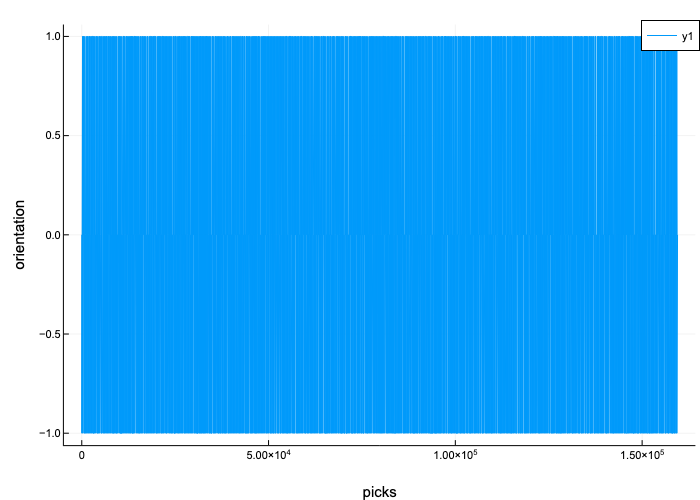

  0.539929 seconds (1.01 M allocations: 95.079 MiB)


In [65]:
@time plot(r.classes, ylabel="orientation", xlabel="picks")|>display;

# Convergence of picking

sparse box picking100%|█████████████████████████████████| Time: 0:00:04


length(picks) = 713


sparse box picking100%|█████████████████████████████████| Time: 0:00:04


length(picks) = 3204


sparse box picking100%|█████████████████████████████████| Time: 0:00:04


length(picks) = 9194


sparse box picking100%|█████████████████████████████████| Time: 0:00:04
collecting neighbours100%|██████████████████████████████| Time: 0:00:00


length(picks) = 20183


sparse box picking100%|█████████████████████████████████| Time: 0:00:04
collecting neighbours100%|██████████████████████████████| Time: 0:00:05


length(picks) = 69151


sparse box picking100%|█████████████████████████████████| Time: 0:00:04
collecting neighbours100%|██████████████████████████████| Time: 0:00:27


length(picks) = 160135


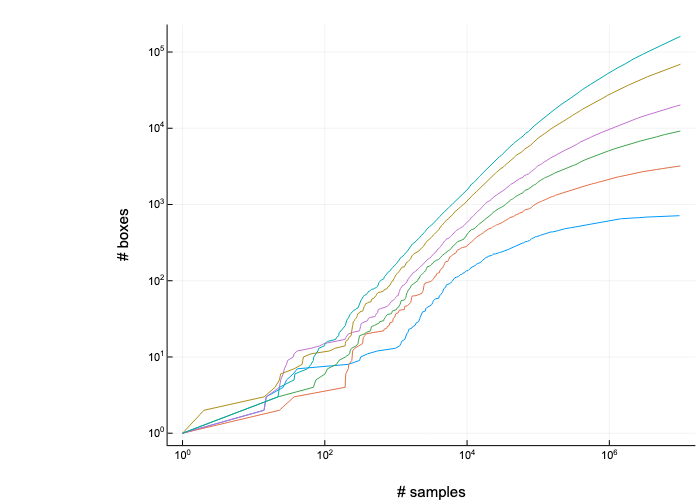

In [21]:
plot()
for n in [3,4,5,6,8,10]
    _, _, order = Sqra.sparseboxpick(r.x, n, ones(size(r.x,2)), r.boundary)
    plot!(order, 1:length(order), )
    accel =  (order[end]-order[end-10]) / 10
    #println(" $(length(order)/size(r.x, 2)  / accel * 100) % verbesserung pro prozent ")
end
plot!(legend=false, xlabel="# samples", ylabel="# boxes", yaxis=:log, xaxis=:log)

# Generator preprocessing

In [9]:
cutoff = 3
prune = Inf

Q, pinds = Sqra.prune_Q(r.Q,Inf)

Q.nzval[Q.nzval.>cutoff] .= cutoff
Q = Sqra.fixdiagonal(Q)

pruned 0 large outbound rates
pruned 0 states without incoming rates


12541×12541 SparseArrays.SparseMatrixCSC{Float64, Int64} with 99367 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

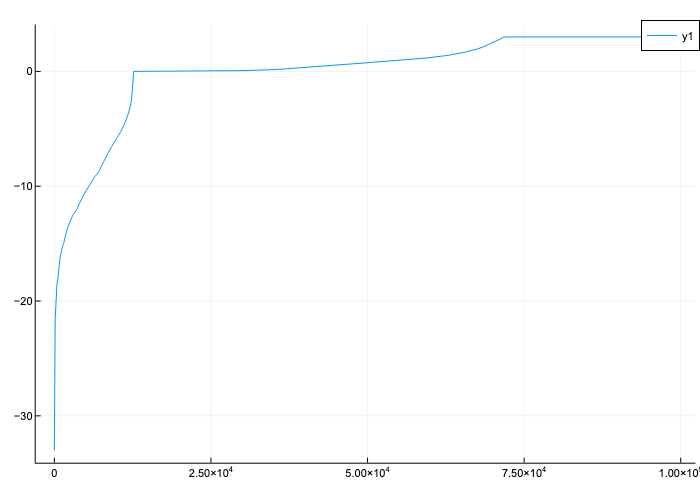

In [10]:
plot((Q.nzval|>sort))

# Committor convergence

In [11]:
Sqra.solve_committor(Q, r.classes[pinds])

LoadError: SingularException(0)

# Spectrum

In [12]:
@time evals, evecs = eigs(Q, which=:LR, maxiter=10000, tol=10)

  2.087857 seconds (4.48 M allocations: 273.488 MiB, 19.26% gc time, 99.05% compilation time)


(ComplexF64[-0.1475671764122306 + 0.0im, -0.7966261258484162 + 0.0im, -1.8944664837860472 + 0.0im, -3.2074719257932913 + 0.0im, -4.4945711114892735 + 0.0im, -6.043124274587199 + 0.0im], ComplexF64[-0.010705250976983669 + 0.0im 0.005518016661157727 + 0.0im … -0.0028558517423887216 + 0.0im 0.0034931182286626673 + 0.0im; -0.013898116354586501 + 0.0im 0.014670317939690276 + 0.0im … 0.002544949149689466 + 0.0im 0.0038144768680137583 + 0.0im; … ; -0.006333613260688547 + 0.0im 0.0045137213484804165 + 0.0im … -0.01626068251582685 + 0.0im -0.002602216051200564 + 0.0im; -0.0081162657879794 + 0.0im 0.001858681185873747 + 0.0im … -0.006749717318176673 + 0.0im 4.865746648047894e-5 + 0.0im], 6, 1, 20, [0.028421907389718715, -0.06938841874877381, -0.1473804498062421, -0.0828561532112862, -0.01905168086002779, 0.0635233506375137, -0.012358328049129638, 0.0400340581663493, -0.008171478918241487, 0.012414471024498887  …  0.015843549068211803, 0.04284768069297001, 0.026374072595923958, 0.0204594852064038

In [13]:
evals

6-element Vector{ComplexF64}:
 -0.1475671764122306 + 0.0im
 -0.7966261258484162 + 0.0im
 -1.8944664837860472 + 0.0im
 -3.2074719257932913 + 0.0im
 -4.4945711114892735 + 0.0im
  -6.043124274587199 + 0.0im

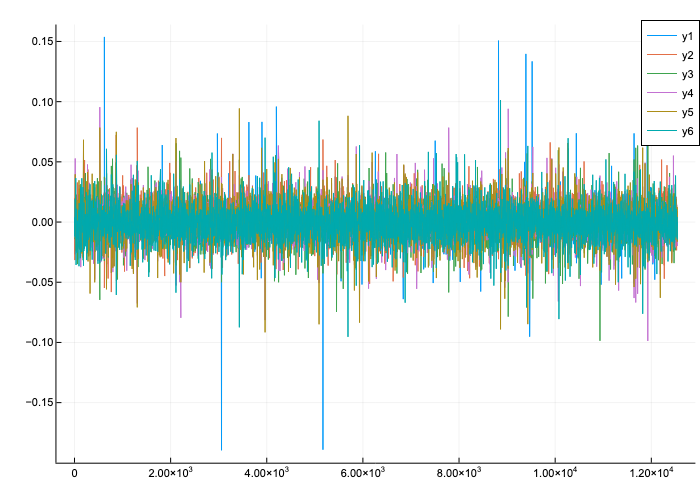

In [14]:
plot(evecs[:,:].|>real)
#plot!(r.classes, alpha=0.5)

# Cell analysis

In [15]:
prob = argmin(diag(r.Q))

5497

In [16]:
@show r.Q[prob,:]
neighs = r.Q[prob,:].nzind;

r.Q[prob, :] =   [416  ]  =  2.85995e291
  [4626 ]  =  3.54671e291
  [4845 ]  =  1.22278e289
  [5497 ]  =  -1.24125e292
  [5541 ]  =  2.51031e291
  [6510 ]  =  5.78385e289
  [10105]  =  3.37218e291
  [11683]  =  5.32815e289


In [17]:
@show r.us[prob]
r.us[neighs]

r.us[prob] = 165.02666398119146


8-element Vector{Float64}:
  -2.7491025397060844
  -2.802906371254066
  -1.385390370968821
 165.02666398119146
  -2.7165030890058035
  -1.7738762209598666
  -2.7902916316770408
  -1.753360044275069

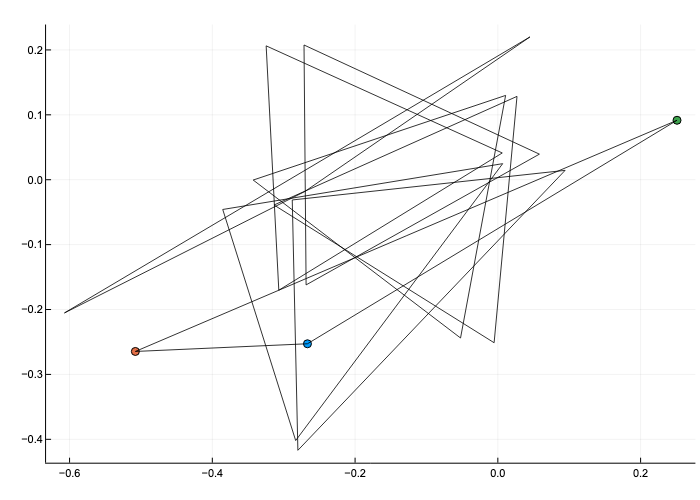

In [18]:
plot(); Sqra.plot_trajectories(r.picks[:,prob])
Sqra.plot_triangles!(r.picks[:, neighs], color=:black, alpha=0.8, legend=false)

# Spectrum again

In [19]:
evals, evecs = eigs(r.Q, which=:SM, nev=6)#, check=0, maxiter=1000, tol=0)
evecs = real.(evecs)
evals

LoadError: SingularException(0)

In [20]:
evecs

12541×6 Matrix{ComplexF64}:
   -0.0107053+0.0im   0.00551802+0.0im  …   0.00349312+0.0im
   -0.0138981+0.0im    0.0146703+0.0im      0.00381448+0.0im
  -0.00307447+0.0im    0.0039833+0.0im      -0.0106567+0.0im
  -0.00955884+0.0im   0.00317276+0.0im      0.00738616+0.0im
  -0.00545934+0.0im   0.00876829+0.0im      -0.0120584+0.0im
   0.00705766+0.0im    0.0200365+0.0im  …  -0.00422746+0.0im
   -0.0267979+0.0im   -0.0315819+0.0im      0.00381682+0.0im
   0.00276322+0.0im   0.00588531+0.0im      0.00104372+0.0im
  -0.00595206+0.0im   0.00290616+0.0im      0.00480697+0.0im
  -0.00392029+0.0im    0.0111989+0.0im     -0.00169179+0.0im
  -0.00501349+0.0im   0.00316529+0.0im  …  -0.00280449+0.0im
  -0.00598821+0.0im   0.00300475+0.0im     -0.00490362+0.0im
   -0.0111979+0.0im   0.00446742+0.0im       0.0188605+0.0im
             ⋮                          ⋱             ⋮
  -0.00821513+0.0im    0.0102204+0.0im     -0.00967229+0.0im
   -0.0058193+0.0im  -4.95268e-5+0.0im  …  -5.47581e-5+0.0im
 

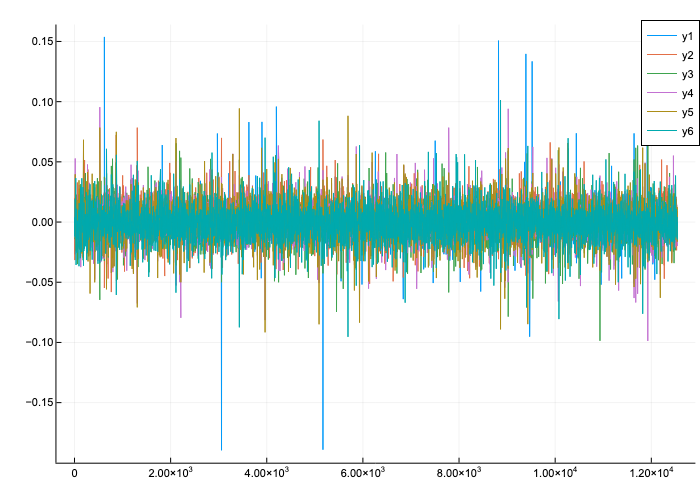

In [21]:
plot(real.(evecs))

In [22]:
step=100
for evec in 1:length(evals)

    col = real.(evecs[:,evec])[1:step:end]
    data = center[:,1:step:end]
    plot();
    plot_trajectories(normalform(data), alpha=0.3, marker_z=col, clims=(-1,1).*std(col), seriescolor=:bwr) |> display

    scatter(data[1,:], data[2,:], alpha=0.3, marker_z=col, clims=(-1,1).*std(col), seriescolor=:bwr) |> display
end

LoadError: MethodError: no method matching axes(::typeof(center), ::Int64)
[0mClosest candidates are:
[0m  axes([91m::RecipesPipeline.Volume[39m, ::Any...) at /Users/alex/.julia/packages/RecipesPipeline/a80Nu/src/utils.jl:108
[0m  axes([91m::Base.Broadcast.Broadcasted{var"#s832", var"#s831", F, Args} where {var"#s832", var"#s831"<:(Tuple{Vararg{T, N}} where T), F, Args<:Tuple}[39m, ::Integer) where N at broadcast.jl:212
[0m  axes([91m::Number[39m, ::Integer) at number.jl:81
[0m  ...